<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

Note:  This material largely follows the text "Numerical Linear Algebra" by Trefethen and Bau (SIAM, 1997) and is meant as a guide and supplement to the material presented there.

In [2]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Iterative Methods

In this lecture we will consider a number of classical and more modern methods for solving sparse linear systems like those we found from our consideration of boundary value problems.

### Motivation:  Direct Methods

Gaussian elimination or other direct methods for solving linear systems of equations but are there other, better methods for solving these systems when there is structure that can be exploited?

For this lecture we will be considering an important type of linear system of equations that arise from discretizing the Poisson problem in one-dimension
$$
    u''(x) = f(x) \quad x \in [a,b] \quad u(a) = \alpha \quad u(b) = \beta.
$$
How might you discretize the above ODE?

Following our finite difference discussion we can setup the following set of algebraic equations:
$$
    \frac{U_{i-1} - 2 U_i + U_{i+1}}{\Delta x^2} = f(x_i).
$$

This forms the $i$th row of the matrix.  See if you can write down this matrix in the form of $Ax = b$ ignoring the boundary conditions for now.

$$
    \frac{1}{\Delta x^2} \begin{bmatrix}
    -2 &  1 &    &    &    \\
     1 & -2 &  1 &    &    \\
       &  1 & -2 &  1 &    \\
       &    &  1 & -2 &  1 \\
       &    &    &  1 & -2 \\
    \end{bmatrix} \begin{bmatrix}
        U_1 \\ U_2 \\ U_3 \\ U_4 \\ U_5
    \end{bmatrix} = 
    \begin{bmatrix}
        f(x_1) - \frac{\alpha}{\Delta x^2} \\ f(x_2) \\ f(x_3) \\ f(x_4) \\ f(x_5) - \frac{\beta}{\Delta x^2} \\
    \end{bmatrix}.
$$

#### Computational Load

Now consider using Gaussian elimination on the above matrix.  For good measure let us consider a 3D problem and discretize each dimension with a $m = 100$ leading to $100 \times 100 \times 100 = 10^6$ unknowns.

Gaussian Elimination - $\mathcal{O}(N^3)$ operations to solve, $(10^6)^3 = 10^{18}$ operations.

Suppose you have a machine that can perform 100 gigaflops (floating point operations per second):
$$
    \frac{10^{18}~ [\text{flop}]}{10^{11}~ [\text{flop / s}]} = 10^7~\text{s} \approx 115~\text{days}.
$$

#### Memory Load

What about memory?

We require $N^2$ to store entire array.  In double precision floating point we would require 8-bytes per entry leading to
$$
    (10^6)^2 ~[\text{entries}] \times 8 ~[\text{bytes / entry}] = 8 \times 10^{12} ~[\text{bytes}] = 8 ~[\text{terabytes}].
$$

The situation really is not as bad as we are making it out to be as long as we take advantage of the sparse nature of the matrices.  In fact for 1 dimensional problems direct methods can be reduced to $\mathcal{O}(N)$ in the case for a tridiagonal system.  The situation is not so great for higher-dimensional problems however unless more structure can be leveraged.  Examples of these types of solvers include fast Fourier methods such as fast Poisson solvers.

## Jacobi and Gauss-Seidel

The Jacobi and Gauss-Seidel methods are simple approaches to introducing an iterative means for solving the problem $Ax = b$ when $A$ is sparse.  Consider the general equation derived from the Poisson problem
$$
    \frac{U_{i-1} - 2 U_i + U_{i+1}}{\Delta x^2} = f(x_i).
$$

If we rearrange this expression to solve for $U_i$ we have
$$
    U_i = \frac{1}{2} (U_{i+1} + U_{i-1}) - f(x_i) \frac{\Delta x^2}{2}.
$$

For a direct method we would simultaneously find the values of $U_i$, $U_{i+1}$ and $U_{i-1}$ but instead consider the iterative scheme computes an update to the equation above by using the past iterate (values we already know)
$$
    U_i^{(k+1)} = \frac{1}{2} (U_{i+1}^{(k)} + U_{i-1}^{(k)}) - f(x_i) \frac{\Delta x^2}{2}.
$$

Since this allows us to evaluate $U_i^{(k + 1)}$ without knowing the values of $U_{i+1}^{(k)} + U_{i-1}^{(k)}$ we directly evaluate this expression!  This process is called **Jacobi iteration**.  It can be shown that for this particular problem Jacobi iteration will converge from any initial guess $U^{(0)}$ although slowly.

Advantages
 - Matrix $A$ is never stored or created
 - Storage is optimal
 - $\mathcal{O}(m)$ are required per iteration

### Example
Let's try to solve the problem before in the BVP section but use Jacobi iterations to replace the direct solve
$$
    u_{xx} = e^x, \quad x \in [0, 1] \quad \text{with} \quad u(0) = 0, \text{ and } u(1) = 3
$$

In [ ]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
N = 100
x_bc = numpy.linspace(a, b, N + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (N + 1)

# Expected iterations needed
iterations_J = int(2.0 * numpy.log(delta_x) / numpy.log(1.0 - 0.5 * numpy.pi**2 * delta_x**2))

# Solve system
# Initial guess for iterations
U_new = numpy.zeros(N + 2)
U_new[0] = u_a
U_new[-1] = u_b
convergence_J = numpy.zeros(iterations_J)
for k in range(iterations_J):
    U = U_new.copy()
    for i in range(1, N + 1):
        U_new[i] = 0.5 * (U[i+1] + U[i-1]) - f(x_bc[i]) * delta_x**2 / 2.0

    convergence_J[k] = numpy.linalg.norm(u_true(x_bc) - U_new, ord=2)
        
# Plot result
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.semilogy(range(iterations_J), convergence_J, 'o')
axes.set_title("Convergence of Jacobi Iterations for Poisson Problem")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")

plt.show()

A slight modification to the above leads also to the Gauss-Seidel method.  Programmtically it is easy to see the modification but in the iteration above we now will have
$$
    U_i^{(k+1)} = \frac{1}{2} (U_{i+1}^{(k)} + U_{i-1}^{(k+1)}) - f(x_i) \frac{\Delta x^2}{2}.
$$

In [ ]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
N = 100
x_bc = numpy.linspace(a, b, N + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (N + 1)

# Expected iterations needed
iterations_GS = int(2.0 * numpy.log(delta_x) / numpy.log(1.0 - numpy.pi**2 * delta_x**2))

# Solve system
# Initial guess for iterations
U = numpy.zeros(N + 2)
U[0] = u_a
U[-1] = u_b
convergence_GS = numpy.zeros(iterations_GS)
success = False
for k in range(iterations_GS):
    for i in range(1, N + 1):
        U[i] = 0.5 * (U[i+1] + U[i-1]) - f(x_bc[i]) * delta_x**2 / 2.0

    convergence_GS[k] = numpy.linalg.norm(u_true(x_bc) - U, ord=2)

# Plot result
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.semilogy(range(iterations_GS), convergence_GS, 'o')
axes.set_title("Convergence of Gauss-Seidel Iterations for Poisson Problem")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")

plt.show()

### Matrix Splitting Methods

One way to view Jacobi and Gauss-Seidel is as a splitting of the matrix $A$ so that
$$
    A = M - N.
$$

Then the system $A U = b$ can be viewed as
$$
    M U - N U = b \Rightarrow MU = NU + b.
$$

Viewing this instead as an iteration we have then
$$
    M U^{(k+1)} = N U^{(k)} + b.
$$
The goal then would be to pick $M$ and $N$ such that $M$ contains as much of $A$ as possible while remaining easier to solve than the original system.

The resulting update for each of these then becomes
$$\begin{aligned}
    U^{(k+1)} &= M^{-1} N U^{(k)} &+& M^{-1} b \\
    &= G U^{(k)} &+&  c
\end{aligned}$$
where $G$ is called the **iteration matrix** and $c = M^{-1} b$.  We also want
$$
    u = G u + c
$$
where $u$ is the true solution of the original $A u = b$, in other words $u$ is the fixed point of the iteration.  Is this fixed point stable though?  If the spectral radius $\rho(G) < 1$ we can show that in fact the iteration is stable.

For Jacobi the splitting is 
$$
    M = -\frac{2}{\Delta x^2} I, \quad \text{and} \quad N = \frac{1}{\Delta x^2} \begin{bmatrix}
        0 & 1 & \\
        1 & 0 & 1 \\
          & \ddots & \ddots & \ddots \\
          & & 1 & 0 & 1 \\
          & &   & 1 & 0
    \end{bmatrix}
$$
(sticking to the Poisson problem).  $M$ is now a diagonal matrix and easy to solve.  

For Gauss-Seidel we have
$$
    M = \frac{1}{\Delta x^2} \begin{bmatrix}
        -2 &  & \\
         1 & -2 &  \\
           & \ddots & \ddots \\
           & & 1 & -2 & \\
           & &   & 1 & -2
    \end{bmatrix} \quad \text{and} \quad 
    N = \frac{1}{\Delta x^2} \begin{bmatrix}
         0 & 1 & \\
          & 0 & 1 \\
          & & \ddots & \ddots \\
           & &  & 0 & 1\\
           & &   &  & 0
    \end{bmatrix}
$$

### Stopping Criteria

How many iterations should we perform?  Let $E^{(k)}$ represent the error present at step $k$.  If we want to reduce the error at the first step $E^{(0)}$ to order $\epsilon$ then we have
$$
    ||E^{(k)}|| \approx \epsilon ||E^{(0)}||.
$$

Under suitable assumption we can bound the error in the 2-norm as
$$
    ||E^{(k)}|| \leq \rho(G)^k ||E^{(0)}||.
$$

Moving back to our estimate of the number of iterations we can combine our two expressions involving the error $E$ by taking $\Delta x \rightarrow 0$ which allows us to write
$$
    k \approx \frac{\log \epsilon}{\log \rho(G)}
$$
taking into account error convergence.  

Picking $\epsilon$ is a bit tricky but one natural criteria to use would be $\epsilon = \mathcal{O}(\Delta x^2)$ since our original discretization was 2nd-order accurate.  This leads to
$$
    k = \frac{2 \cdot \log \Delta x}{\log \rho}.
$$
This also allows us to estimate the total number of operations that need to be used.

For Jacobi we have the spectral radius of $G$ as
$$
    \rho_J \approx 1 - \frac{1}{2} \pi^2 \Delta x^2.
$$
so that
$$
    k = \mathcal{O}(m^2 \log m) \quad \text{as} \quad m \rightarrow \infty
$$
where $m$ here is now the number of points used.  

Combining this with the previous operation count per iteration we find that Jacobi would lead to $\mathcal{O}(m^3 \log m)$ work which is not very promising.  

For two dimensions we have $\mathcal{O}(m^4 \log m)$ so even compared to Gaussian elimination this approach is not ideal.

What about Gauss-Seidel?  Here the spectral radius is approximately
$$
    \rho_{GS} \approx 1 - \pi^2 \Delta x^2
$$
so that
$$
    k = \frac{2 \cdot \log \Delta x}{\log (1 - \pi^2 \Delta x^2)}
$$
which still does not lead to any advantage over direct solvers.  It does show that Gauss-Seidel does actually converge faster due to the factor of 2 difference between $\rho_J$ and $\rho_{GS}$.

## Successive Overrelaxation (SOR)

Well that's a bit dissapointing isn't it?  These iterative schemes do not seem to be worth much but it turns out we can do better with a slight modification to Gauss-Seidel.  

If you look at Gauss-Seidel iteration it turns out it moves $U$ in the correct direction to $u$ but is very conservative in the amount.  If instead we do
$$\begin{aligned}
    U^{GS}_i &= \frac{1}{2} \left(U^{(k+1)}_{i-1} + U^{(k)}_{i+1} - \Delta x^2 f_i\right) \\
    U^{(k+1)}_i &= U_i^{(k)} + \omega \left( U_i^{GS} - U_i^{(k)}\right )
\end{aligned}$$
where we get to pick $\omega$ we can do much better.  

$$\begin{aligned}
    U^{GS}_i &= \frac{1}{2} \left(U^{(k+1)}_{i-1} + U^{(k)}_{i+1} - \Delta x^2 f_i\right) \\
    U^{(k+1)}_i &= U_i^{(k)} + \omega \left( U_i^{GS} - U_i^{(k)}\right )
\end{aligned}$$

If $\omega = 1$ then we get back Gauss-Seidel.  

If $\omega < 1$ we move even less and converges even more slowly (although is sometimes used for multigrid under the name underrelaxation).  

If $\omega > 1$ then we move further than Gauss-Seidel suggests and any method where $\omega > 1$ is known as **successive overrelaxation** (SOR).

We can write this as a matrix splitting method as well.  We can combine the two-step formula above to find
$$
    U^{(k+1)}_i = \frac{\omega}{2} \left( U^{(k+1)}_{i-1} + U^{(k)}_{i+1} - \Delta x^2 f_i \right ) + (1 - \omega) U_i^{(k)}
$$
corresponding to a matrix splitting of
$$
    M = \frac{1}{\omega} (D - \omega L) \quad \text{and} \quad  N = \frac{1}{\omega} ((1-\omega) D + \omega U)
$$
where $D$ is the diagonal of the matrix $A$, and $L$ and $U$ are the lower and upper triangular parts without the diagonal of $A$.

It can be shown that picking an $\omega$ such that $0 < \omega < 2$ the SOR method converges.  

It turns out we can also find an optimal $\omega$ for a wide class of problems.  For Poisson problems in any number of space dimensions for instance it can be shown that SOR method converges optimaly if
$$
    \omega_{opt} = \frac{2}{1 + \sin(\pi \Delta x)} \approx 2 - 2 \pi \Delta x.
$$

What about the number of iterations?  We can follow the same tactic as before with the spectral radius of $G_{SOR}$ now
$$
    \rho = \omega_{opt} - 1 \approx 1 - 2 \pi \Delta x.
$$

This leads to an iteration count of
$$
    k = \mathcal{O}(m \log m)
$$
an order of magnitude better than Gauss-Seidel alone!

In [ ]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
N = 100
x_bc = numpy.linspace(a, b, N + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (N + 1)

# SOR parameter
omega = 2.0 / (1.0 + numpy.sin(numpy.pi * delta_x))

# Expected iterations needed
iterations_SOR = int(2.0 * numpy.log(delta_x) / numpy.log(omega - 1.0))

# Solve system
# Initial guess for iterations
U = numpy.zeros(N + 2)
U[0] = u_a
U[-1] = u_b
convergence_SOR = numpy.zeros(iterations_SOR)
for k in range(iterations_SOR):
    for i in range(1, N + 1):
        U_gs = 0.5 * (U[i-1] + U[i+1] - delta_x**2 * f(x_bc[i]))
        U[i] += omega * (U_gs - U[i])

    convergence_SOR[k] = numpy.linalg.norm(u_true(x_bc) - U, ord=2)
        
# Plot result
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.semilogy(range(iterations_SOR), convergence_SOR, 'o')
axes.set_title("Convergence of SOR Iterations for Poisson Problem")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")
plt.show()

In [ ]:
# Plotting all the convergence rates
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.semilogy(range(iterations_SOR), convergence_J[:iterations_SOR], 'r', label="Jacobi")
axes.semilogy(range(iterations_SOR), convergence_GS[:iterations_SOR], 'b', label="Gauss-Seidel")
axes.semilogy(range(iterations_SOR), convergence_SOR, 'k', label="SOR")
axes.legend(loc=3)
axes.set_title("Comparison of Convergence Rates")
axes.set_xlabel("Iteration")
axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")
plt.show()

## Descent Methods

One special case of matrices are amenable to another powerful way to iterate to the solution.  A matrix is said to be **symmetric positive definite** (SPD) if 
$$
    x^T A x > 0 \quad \forall \quad x \neq 0.
$$

As an example check that the matrix
$$
    A = \begin{bmatrix}
        2 &-1 &0 &0 \\
        -1 & 2 & -1 & 0 \\
        0 & -1 & 2 & -1 \\
        0 & 0 & -1 & 2
    \end{bmatrix}
$$
is symmetric positive definite.

Now define a function $\phi: \mathbb R^m \rightarrow \mathbb R$ such that
$$
    \phi(u) = \frac{1}{2} u^T A u - u^T f.
$$
This is a quadratic function in the variables $u_i$ and in the case where $m = 2$ forms a parabolic bowl.  Since this is a quadratic function there is a unique minimum, $u^\ast$.  

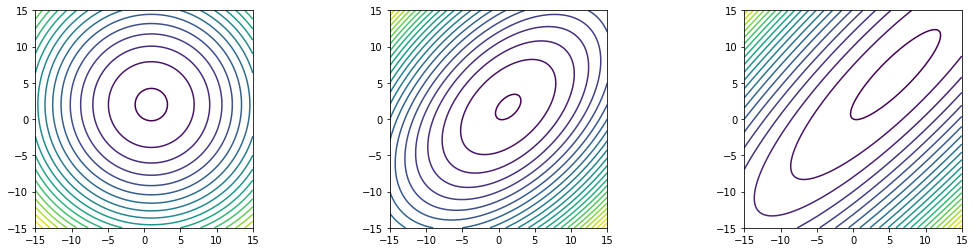

In [16]:
phi = lambda X, Y, A: 0.5 * (A[0, 0] * X**2 + A[0, 1] * X * Y + A[1, 0] * X * Y + A[1, 1] * Y**2) - X * f[0] - Y * f[1]

x = numpy.linspace(-15, 15, 100)
y = numpy.linspace(-15, 15, 100)
X, Y = numpy.meshgrid(x, y)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 3)
axes = fig.add_subplot(1, 3, 1, aspect='equal')
A = numpy.identity(2)
axes.contour(X, Y, phi(X, Y, A), 25)

axes = fig.add_subplot(1, 3, 2, aspect='equal')
A = numpy.array([[2, -1], [-1, 2]])
axes.contour(X, Y, phi(X, Y, A), 25)

axes = fig.add_subplot(1, 3, 3, aspect='equal')
A = numpy.array([[2, -1.8], [-1.7, 2]])
axes.contour(X, Y, phi(X, Y, A), 25)
plt.show()

Lets see how approaching the problem like this helps us:

$$
    \phi(u) = \frac{1}{2} u^T A u - u^T f.
$$
For the $m = 2$ case write the function $\phi(u)$ out.

$$
    \phi(u) = \frac{1}{2} (A_{11} u_1^2 + A_{12} u_1 u_2 + A_{21} u_1 u_2 + A_{22} u^2_2) - u_1 f_1 - u_2 f_2
$$

What property of the matrix $A$ simplifies the expression above?

Symmetry!  This implies that $A_{21} = A_{12}$ and the expression above simplifies to 
$$
   \phi(u) = \frac{1}{2} (A_{11} u_1^2 + 2 A_{12} u_1 u_2 + A_{22} u^2_2) - u_1 f_1 - u_2 f_2
$$

Now write two expressions that when evaluated at $u^\ast$ are identically 0 that express that $u^\ast$ minimizes $\phi(u)$.

$$
   \phi(u) = \frac{1}{2} (A_{11} u_1^2 + 2 A_{12} u_1 u_2 + A_{22} u^2_2) - u_1 f_1 - u_2 f_2
$$
   

Since $u^\ast$ minimizes $\phi(u)$ we know that the first derivatives should be zero at the minimum:
   $$\begin{aligned}
       \frac{\partial \phi}{\partial u_1} &= A_{11} u_1 + A_{12} u_2 - f_1 = 0 \\
       \frac{\partial \phi}{\partial u_1} &= A_{21} u_1 + A_{22} u_2 - f_2 = 0
   \end{aligned}$$
   Note that these equations can be rewritten as
   $$
       A u = f.
   $$

The conclusion here then is that finding the minimum of $\phi$ is equivalent to solving the system $A u = f$!  This is a common type of reformulation for many problems where it may be easier to treat a given equation as a minimization problem rather than directly solve it.

Note that this is not quite the matrix that we have been using for our Poisson problem so far which is actually symmetric negative definite although these same methods work as well.  In this case we actually want to find the maximum of $\phi$ instead, other than that everything is the same.

Also note that if $A$ is indefinite then the eigenvalues of $A$ will change sign and instead of a stable minimum or maximum we have a saddle point which are much more difficult to handle (GMRES can for instance).

### Method of Steepest Descent

So now we turn to finding the $u^\ast$ that minimizes the function $\phi(u)$.  The simplest approach to this is called the **method of steepest descent** which finds the direction of the largest gradient of $\phi(u)$ and goes in that direction.  

Mathematically we then have
$$
    u^{(k+1)} = u^{(k)} - \alpha^{(k)} \nabla \phi(u^{(k)})
$$
where $\alpha^{(k)}$ will be the step size chosen in the direction we want to go.  

We can find $\alpha$ by
$$
    \alpha^{(k)} = \min_{\alpha \in \mathbb R} \phi\left(u^{(k)} - \alpha \nabla \phi(u^{(k)}\right),
$$
i.e. the $\alpha$ that takes us just far enough so that if we went any further $\phi$ would increase.  

This implies that $\alpha^{(k)} \geq 0$ and $\alpha^{(k)} = 0$ only if we are at the minimum of $\phi$.  We can compute the gradient of $\phi$ as
$$
    \nabla \phi(u^{(k)}) = A u^{(k)} - f \equiv -r^{(k)}
$$
where $r^{(k)}$ is the residual defined as
$$
    r^{(k)} = f - A u^{(k)}.
$$

Looking back at the definition of $\alpha^{(k)}$ then leads to the conclusion that the $\alpha$ that would minimize the expression would be the one that satisfies
$$
    \frac{\text{d} \phi(\alpha)}{\text{d} \alpha} = 0. 
$$

To find this note that
$$
    \phi(u + \alpha r) = \left(\frac{1}{2} u^T A u - u^T f \right) + \alpha(r^T A u - r^T f) + \frac{1}{2} \alpha^2 r^T A r
$$
so that the derivative becomes
$$
    \frac{\text{d} \phi(\alpha)}{\text{d} \alpha} = r^T A u - r^T f + \alpha r^T A r
$$

Setting this to zero than leads to
$$
    \alpha = \frac{r^T r}{r^T A r}.
$$

In [ ]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
N = 50
x_bc = numpy.linspace(a, b, N + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (N + 1)

# Construct matrix A
A = numpy.zeros((N, N))
diagonal = numpy.ones(N) / delta_x**2
A += numpy.diag(diagonal * 2.0, 0)
A += numpy.diag(-diagonal[:-1], 1)
A += numpy.diag(-diagonal[:-1], -1)

# Construct right hand side
b = -f(x)
b[0] += u_a / delta_x**2
b[-1] += u_b / delta_x**2

# Algorithm parameters
MAX_ITERATIONS = 10000
tolerance = 1e-3

# Solve system
U = numpy.empty(N)
convergence_SD = numpy.zeros(MAX_ITERATIONS)
success = False
for k in range(MAX_ITERATIONS):
    r = b - numpy.dot(A, U)
    if numpy.linalg.norm(r, ord=2) < tolerance:
        success = True
        break
        
    alpha = numpy.dot(r, r) / numpy.dot(r, numpy.dot(A, r))
    U = U + alpha * r

    convergence_SD[k] = numpy.linalg.norm(u_true(x) - U, ord=2)
        
if not success:
    print("Iteration failed to converge!")
    print(convergence_SD[-1])
else:
    # Plot result
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(x, U, 'o', label="Computed")
    axes.plot(x_bc, u_true(x_bc), 'k', label="True")
    axes.set_title("Solution to $u_{xx} = e^x$")
    axes.set_xlabel("x")
    axes.set_ylabel("u(x)")

    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.semilogy(range(k), convergence_SD[:k], 'o')
    axes.set_title("Convergence of Steepest Descent for Poisson Problem")
    axes.set_xlabel("Iteration")
    axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")
    plt.show()

#### Convergence of Steepest Descent

What controls the convergence of steepest descent?  It turns out that the shape of the parabolic bowl formed by $\phi$ is the major factor determining the convergence of steepest descent.  For example, if $A$ is a scalar multiple of the identity than these ellipses are actually circles and steepest descent converges in $m$ steps.  If $A$ does not lead to circles, the convergence is based on the ratio between the semi-major and semi-minor axis of the resulting ellipses $m$ dimensional ellipses.  This is controlled by the smallest and largest eigenvalues of the matrix $A$ hence why steepest descent grows increasingly difficult as $m$ increases for the Poisson problem.  Note that this also relates to the condition number of the matrix in the $\ell_2$ norm.

![Ellipses](./images/ellipses.png)

Iteration count: 1
Iteration count: 8
Iteration count: 67


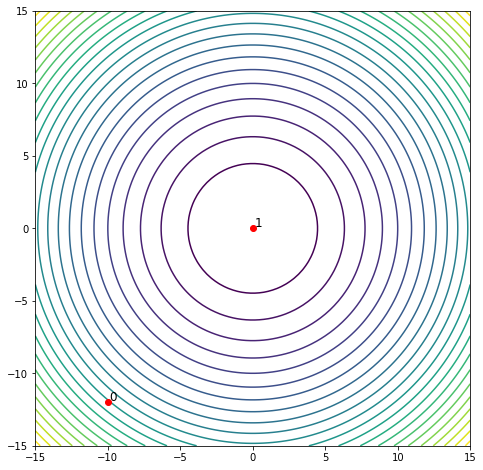

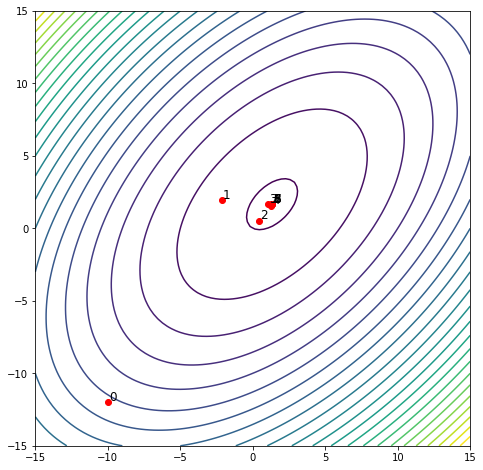

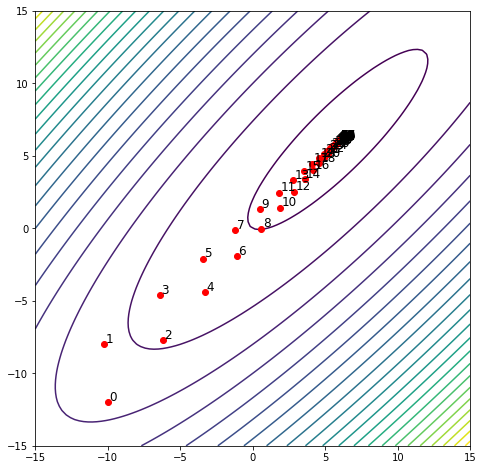

In [23]:
def steepest_descent(A, U, b, axes):
    MAX_ITERATIONS = 10000
    tolerance = 1e-3
    success = False
    for k in range(MAX_ITERATIONS):
        axes.text(U[0] + 0.1, U[1] + 0.1, str(k), fontsize=12)
        axes.plot(U[0], U[1], 'ro')
        r = b - numpy.dot(A, U)
        if numpy.linalg.norm(r, ord=2) < tolerance:
            success = True
            break

        alpha = numpy.dot(r, r) / numpy.dot(r, numpy.dot(A, r))
        U = U + alpha * r
        
    if success:
        return k
    else:
        raise Exception("Iteration did not converge.")

phi = lambda X, Y, A: 0.5 * (A[0, 0] * X**2 + A[0, 1] * X * Y + A[1, 0] * X * Y + A[1, 1] * Y**2) - X * f[0] - Y * f[1]

x = numpy.linspace(-15, 15, 100)
y = numpy.linspace(-15, 15, 100)
X, Y = numpy.meshgrid(x, y)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
# fig.set_figwidth(fig.get_figwidth() * 3)
# axes = fig.add_subplot(1, 3, 1, aspect='equal')
axes = fig.add_subplot(1, 1, 1, aspect='equal')
A = numpy.identity(2)
f = numpy.array([0.0, 0.0])
axes.contour(X, Y, phi(X, Y, A), 25)
print("Iteration count: %s" % steepest_descent(A, numpy.array([-10.0, -12.0]), f, axes))


fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
# axes = fig.add_subplot(1, 3, 2, aspect='equal')
axes = fig.add_subplot(1, 1, 1, aspect='equal')
A = numpy.array([[2, -1], [-1, 2]])
f = numpy.array([1.0, 2.0])
axes.contour(X, Y, phi(X, Y, A), 25)
print("Iteration count: %s" % steepest_descent(A, numpy.array([-10.0, -12.0]), f, axes))

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(1, 1, 1, aspect='equal')
# axes = fig.add_subplot(1, 3, 3, aspect='equal')
A = numpy.array([[2, -1.8], [-1.7, 2]])
f = numpy.array([1.0, 2.0])
axes.contour(X, Y, phi(X, Y, A), 25)
print("Iteration count: %s" % steepest_descent(A, numpy.array([-10.0, -12.0]), f, axes))



### $A$-Conjugate Search Directions and Conjugate Gradient

An alternative to steepest descent is to choose a slightly different direction to descend down.  Generalizing our step from above let the iterative scheme be  
$$
    u^{(k+1)} = u^{(k)} - \alpha^{(k)} p^{(k)}
$$
and as before we want to pick an $\alpha$ such that
$$
    \min_{\alpha} \phi(u^{(k)} - \alpha p^{(k)})
$$
leading again to the choice of $\alpha$ of
$$
    \alpha^{(k)} = \frac{(p^{(k)})^T p^{(k)}}{(p^{(k)})^T A p^{(k)}}
$$
accept now we are also allowed to pick the search direction $p^{(k)}$.  

Ways to choose $p^{(k)}$:
 - One bad choice for $p$ would be orthogonal to $r$ since this would then be tangent to the level set (ellipse) of $\phi(u^{(k)})$ and would cause it to only increase so we want to make sure that $p^T r \neq 0$ (the inner-product).
 - We also want to still move downwards so require that $\phi(u^{(k+1)}) < \phi(u^{(k)})$.

We know that $r^{(k)}$ is not always the best direction to go in but what might be better?  We could head directly for the minimum but how do we do that without first knowing $u^\ast$?  

It turns out when $m=2$ we can do this from any initial guess $u^{(0)}$ and initial direction $p^{(k)}$ we will arrive at the minimum in 2 steps if we choose the second search direction dependent on
$$
    (p^{(1)})^T A p^{(0)} = 0.
$$
In general if two vectors satisfy this property they are said to be $A$-conjugate.

Note that if $A = I$ then these two vectors would be orthogonal to each other and in this sense $A$-conjugacy is a natural extension from orthogonality and the simple case from before where the ellipses are circles to the case where we can have very distorted ellipses.  

In fact the vector $p^{(0)}$ is tangent to the level set that $u^{(1)}$ lies on and therefore choosing $p^{(1)}$ so that it is $A$-conjugate to $p^{(0)}$ then always heads to the center of the ellipse.  

In other words, once we know a tangent to one of the ellipses we can always choose a direction that minimizes in one of the dimensions of the search space.  Choosing the $p^{(k)}$ iteratively this way forms the basis of the **conjugate gradient** method.

![Ellipses CG](./images/ellipses_CG.png)

Now to generalize beyond $m = 2$ consider the $m=3$ case.  As stated before we are now in a three-dimensional space where the level-sets are concentric ellipsoids.  Taking a slice through this space will lead to an ellipse on the slice.

1. Start with an initial guess $u^{(0)}$ and choose a search direction $p^{(0)}$.
1. Minimize $\phi(u)$ in the direction $u^{(0)} + \alpha p^{(0)}$ resulting in the choice
$$
    \alpha^{(0)} = \frac{(p^{(0)})^T p^{(0)}}{(p^{(0)})^T A p^{(0)}}
$$
as we saw before.  Now set $u^{(1)} = u^{(0)} + \alpha^{(0)} p^{(0)}$.
1. Choose $p^{(1)}$ to be $A$-conjugate to $p^{(0)}$.  In this case there are an infinite set of vectors that are possible that satisfy $(p^{(1)})^T A p^{(0)} = 0$.  Beyond requiring $p^{(1)}$ to be $A$-conjugate we also want it to be linearly-independent to $p^{(0)}$.
1. Again choose an $\alpha^{(1)}$ that minimizes the residual (again tangent to the level sets of $\phi$) in the direction $p^{(1)}$ and repeat the process

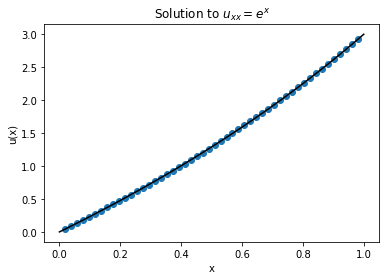

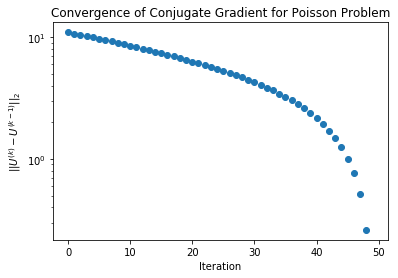

In [31]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
N = 50
x_bc = numpy.linspace(a, b, N + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (N + 1)

# Construct matrix A
A = numpy.zeros((N, N))
diagonal = numpy.ones(N) / delta_x**2
A += numpy.diag(diagonal * 2.0, 0)
A += numpy.diag(-diagonal[:-1], 1)
A += numpy.diag(-diagonal[:-1], -1)

# Construct right hand side
b = -f(x)
b[0] += u_a / delta_x**2
b[-1] += u_b / delta_x**2

# Algorithm parameters
MAX_ITERATIONS = N
tolerance = 1e-8

# Solve system
U = numpy.zeros(N)
convergence_CG = numpy.zeros(MAX_ITERATIONS)
success = False
r = numpy.dot(A, U) - b
p = -r
r_prod_prev = numpy.dot(r, r)
for k in range(MAX_ITERATIONS):
    w = numpy.dot(A, p)
    alpha = r_prod_prev / numpy.dot(p, w)
    U += alpha * p
    r += alpha * w
    beta = numpy.dot(r, r) / r_prod_prev
    r_prod_prev = numpy.dot(r, r)
    if numpy.linalg.norm(r, ord=2) < tolerance:
        success = True
        break
    p = beta * p - r
    convergence_CG[k] = numpy.linalg.norm(u_true(x) - U, ord=2)

if not success:
    print("Iteration failed to converge!")
else:
    # Plot result
    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.plot(x, U, 'o', label="Computed")
    axes.plot(x_bc, u_true(x_bc), 'k', label="True")
    axes.set_title("Solution to $u_{xx} = e^x$")
    axes.set_xlabel("x")
    axes.set_ylabel("u(x)")

    fig = plt.figure()
    axes = fig.add_subplot(1, 1, 1)
    axes.semilogy(convergence_CG[:k+2], 'o')
    axes.set_title("Convergence of Conjugate Gradient for Poisson Problem")
    axes.set_xlabel("Iteration")
    axes.set_ylabel("$||U^{(k)} - U^{(k-1)}||_2$")
    plt.show()

Iteration count: 0
Iteration count: 1
Iteration count: 12


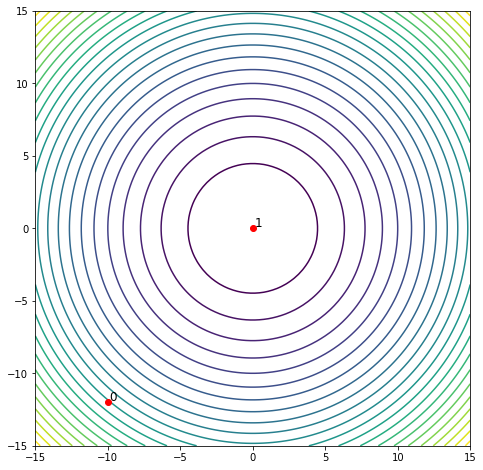

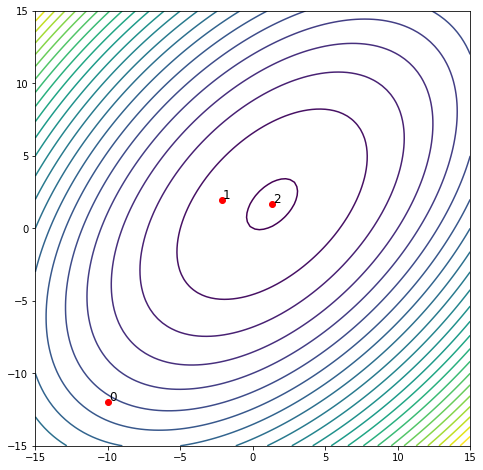

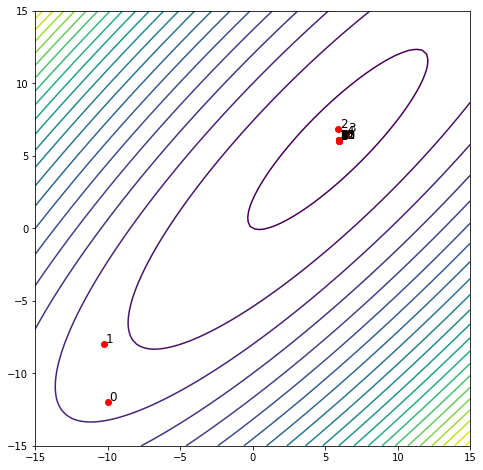

In [30]:
def CG(A, U, b, axes):
    MAX_ITERATIONS = 10000
    tolerance = 1e-3
    success = False        
    r = numpy.dot(A, U) - b
    p = -r
    r_prod_prev = numpy.dot(r, r)
    axes.text(U[0] + 0.1, U[1] + 0.1, str(0), fontsize=12)
    axes.plot(U[0], U[1], 'ro')
    for k in range(MAX_ITERATIONS):
        w = numpy.dot(A, p)
        alpha = r_prod_prev / numpy.dot(p, w)
        U += alpha * p
        axes.text(U[0] + 0.1, U[1] + 0.1, str(k + 1), fontsize=12)
        axes.plot(U[0], U[1], 'ro')
        r += alpha * w
        beta = numpy.dot(r, r) / r_prod_prev
        r_prod_prev = numpy.dot(r, r)
        if numpy.linalg.norm(r, ord=2) < tolerance:
            success = True
            break
        p = beta * p - r
        
    if success:
        return k
    else:
        raise Exception("Iteration did not converge.")

phi = lambda X, Y, A: 0.5 * (A[0, 0] * X**2 + A[0, 1] * X * Y + A[1, 0] * X * Y + A[1, 1] * Y**2) - X * f[0] - Y * f[1]

x = numpy.linspace(-15, 15, 100)
y = numpy.linspace(-15, 15, 100)
X, Y = numpy.meshgrid(x, y)

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
# fig.set_figwidth(fig.get_figwidth() * 3)
# axes = fig.add_subplot(1, 3, 1, aspect='equal')
axes = fig.add_subplot(1, 1, 1, aspect='equal')
A = numpy.identity(2)
f = numpy.array([0.0, 0.0])
axes.contour(X, Y, phi(X, Y, A), 25)
print("Iteration count: %s" % CG(A, numpy.array([-10.0, -12.0]), f, axes))

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
# axes = fig.add_subplot(1, 3, 2, aspect='equal')
axes = fig.add_subplot(1, 1, 1, aspect='equal')
A = numpy.array([[2, -1], [-1, 2]])
f = numpy.array([1.0, 2.0])
axes.contour(X, Y, phi(X, Y, A), 25)
print("Iteration count: %s" % CG(A, numpy.array([-10.0, -12.0]), f, axes))

fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.set_figheight(fig.get_figheight() * 2)
axes = fig.add_subplot(1, 1, 1, aspect='equal')
# axes = fig.add_subplot(1, 3, 3, aspect='equal')
A = numpy.array([[2, -1.8], [-1.7, 2]])
f = numpy.array([1.0, 2.0])
axes.contour(X, Y, phi(X, Y, A), 25)
print("Iteration count: %s" % CG(A, numpy.array([-10.0, -12.0]), f, axes))

plt.show()

### Preconditioning

One way to get around the difficulties with these types of methods due to the distortion of the ellipses (and consequently the conditioning of the matrix) is to precondition the matrix.  The basic idea is that we take our original problem $A u = f$ and instead solve
$$
    M^{-1} A u = M^{-1} f.
$$

Note that since we need to find the inverse of $M$, this matrix should be nice.  A couple of illustrative examples may help to illustrate why this might be a good idea:

 - If $M = A$ then we essentially have solved our problem already although that does not help us much
 - If $M = \text{diag}(A)$, then $M^{-1}$ is easily computed and it turns out for some problems this can decrease the condition number of $M^{-1} A$ significantly.  Note though that this is not actually helpful in the case of the Poisson problem.
 - If $M$ is based on another iterative method used on $A$, for instance Gauss-Seidel, these can be effective general use preconditioners for many problems.
 

So the next question then becomes how to choose a preconditioner.  This is usually very problem specific and a number of papers suggest strategies for particular problems.